In [ ]:
!pip install ale-py
!pip install gym[accept-rom-license,atari]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 19.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=d8b5b4f27dbbab332cd6b3d99842b4db8b72780c441bb4e6a8c145c838573989
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.8.1
    Uninstalling ale-py-0.8.1:
      Successfully uninstalled ale-py-0.8.1


1, Use GPU on Colab

In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.optimizers import Adam
from collections import deque
import random
import matplotlib.pyplot as plt
import cv2
from IPython.display import display
import ipywidgets as widgets

2. Build the Model

In [ ]:
# Define the DQN agent class
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.05#0.001
        self.model = self._build_model()

    # Build the DQN model
    def _build_model(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=self.state_size))
        model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # Store the agent's experiences in the replay memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Make an action based on the current state
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    # Train the DQN model using experiences from the replay memory
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


3. Get the Environment and Train

In [ ]:
# Set up the Pong environment
env = gym.make('PongDeterministic-v4',render_mode='rgb_array')
state_size = env.observation_space.shape
action_size = env.action_space.n

# Initialize the DQN agent
agent = DQNAgent(state_size, action_size)

# Training parameters
batch_size = 32
n_episodes = 120#1000

# Initialize an empty list to store the episode rewards
episode_rewards = []

# Main training loop
for episode in range(n_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size[0], state_size[1], state_size[2]])
    done = False
    total_reward = 0

    while not done:
        # Uncomment the following line to render the game
        # env.render()

        # Agent takes an action
        action = agent.act(state)

        # Perform the action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size[0], state_size[1], state_size[2]])

        # Store the experience in the replay memory
        agent.remember(state, action, reward, next_state, done)

        # Update the current state
        state = next_state

        # Accumulate the episode reward
        total_reward += reward

    # Perform experience replay and train the agent
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

    # Store the episode reward in the list
    episode_rewards.append(total_reward)

    # Print the episode statistics
    print("Episode: {}, Total Reward: {}, Epsilon: {:.2}".format(episode, total_reward, agent.epsilon))

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


流式输出内容被截断，只能显示最后 5000 行内容。
1/1 [==============================] - 0s 28ms/step
Episode: 102, Total Reward: -20.0, Epsilon: 0.6
1/1 [==============================] - 0s 27ms/step
Episode: 103, Total Reward: -20.0, Epsilon: 0.59
1/1 [==============================] - 0s 28ms/step
Episode: 104, Total Reward: -20.0, Epsilon: 0.59
1/1 [==============================] - 0s 25ms/step
Episode: 105, Total Reward: -21.0, Epsilon: 0.59
1/1 [==============================] - 0s 19ms/step
Episode: 106, Total Reward: -21.0, Epsilon: 0.58
1/1 [==============================] - 0s 26ms/step
Episode: 107, Total Reward: -20.0, Epsilon: 0.58
1/1 [==============================] - 0s 27ms/step
Episode: 108, Total Reward: -21.0, Epsilon: 0.58
1/1 [==============================] - 0s 27ms/step
Episode: 109, Total Reward: -20.0, Epsilon: 0.58
1/1 [==============================] - 0s 38ms/step
Episode: 110, Total Reward: -18.0, Epsilon: 0.57
1/1 [==============================] - 0s 31ms/step
Episode: 111,

KeyboardInterrupt: ignored

Note: An error occurred at the end of the training process. This error is due to the excessive use of GPU resources on the Colab, resulting in a decrease in the program's running speed. Therefore, I chose to manually stop the training. This error is not caused by the program itself.

4. Plot the Rewards

The Best Rewards is -17

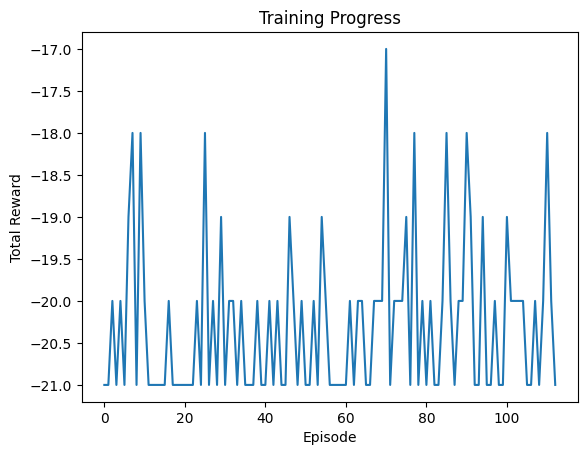

Max Reward:  -17.0


In [ ]:
# Plot the training progress
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.show()
print('Max Reward: ',max(episode_rewards))

5. Load the Google Drive

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
path ="/content/drive/My Drive/"
os.chdir(path)
# os.listdir(path)

Mounted at /content/drive


In [ ]:
import os
print(os.getcwd())

/content/drive/My Drive


6. Save an One-minute Video for the Trained Agent playing the game

In [ ]:
import gym
from gym.wrappers import TimeLimit
from gym.wrappers.monitoring import video_recorder
import moviepy.editor as mpy
from IPython.display import display
import numpy as np
import imageio
from IPython.display import display
import ipywidgets as widgets

state = env.reset()
state = np.reshape(state, [1, state_size[0], state_size[1], state_size[2]])
done = False
video = video_recorder.VideoRecorder(env, path='/content/drive/MyDrive/maching learning in finance/ouput.mp4')

while not done:
    env.render(mode='rgb_array')  # Render the game

    # Agent takes an action
    action = agent.act(state)

    # Perform the action and observe the next state and reward
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, state_size[0], state_size[1], state_size[2]])

    # Update the current state
    state = next_state
    video.capture_frame()  # Capture every frame

# Shut dowm the video_recorder
video.close()

  logger.deprecation(

  logger.deprecation(



1/1 [==============================] - 0s 18ms/step


See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



1/1 [==============================] - 0s 27ms/step


7. Show the video

In [ ]:
# Load and display game playback videos using Moviepy
video_path = '/content/drive/MyDrive/maching learning in finance/ouput.mp4'
video = mpy.VideoFileClip(video_path)
video.ipython_display(width=500)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  87%|████████▋ | 798/918 [00:00<00:00, 1596.28it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/maching learning in finance/3036198839.mp4, 100800 bytes wanted but 0 bytes read,at frame 917/918, at time 30.57/30.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready __temp__.mp4
